In [1]:
import os
import sys

# Get the current directory of the script
current_dir = os.getcwd() # path.dirname(os.path.abspath(__file__))

# Append the relative path to Otter/src from the current directory
sys.path.append(os.path.join(current_dir, "Otter", "src"))

import torch
from model import perceivingContrastive, VisionTransformer, OldVisionTransformer
from data import load_all_data, prepare_dataloader, prepare_dataloader_precomputed_perceiver_embeddings
from train import train_one_epoch
from utils import load_pretrained_perceiver_from_file
from Otter.src.otter_ai.models.flamingo.modeling_flamingo import FlamingoPerceiverResampler
from sklearn.preprocessing import LabelEncoder
from transformers import CLIPVisionModel, CLIPProcessor, CLIPTextModelWithProjection
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder

%load_ext autoreload
%autoreload 2

In [28]:
path = './saved_weights/dataset_perceiver_embeddings_no_pooling.pkl'
#path = './saved_weights/dataset_embeddings_with_perceiver_pooled.pkl'
root_dirs = ['../data/acc_watch_clip', '../data/acc_phone_clip', '../data/gyro_clip', '../data/orientation_clip']
video_root_dir = '../data/video'
dataset = load_all_data(root_dirs, video_root_dir, path=path)

train_dataloader, test_dataloader, label_mapping = prepare_dataloader_precomputed_perceiver_embeddings(dataset, batch_size=40000, num_workers=4, drop_last=False)

In [39]:
configs = {'256_sequence_aligned': {'width':256,
                                  'patch_size':16,
                                  'padding':0,
                                  'dropout':0.3,
                                  'path':'../Checkpoints/bqnl4hih/upbeat-sweep-1/epoch260_avg_train_loss_1.747.pt', #'../Checkpoints/47adm56v/peachy-sweep-26/epoch170_avg_train_loss_1.411.pt',
                                  'num_class_tokens':64,
                                  'loss_remapping':False},
          '256_sequence_aligned_temp5': {'width':256,
                                      'patch_size':16,
                                      'padding':0,
                                      'dropout':0.3,
                                      'path':'../Checkpoints/m0npleep/daily-sweep-1/epoch260_avg_train_loss_2.408.pt', #'../Checkpoints/st90oo9d/autumn-sweep-1/epoch290_avg_train_loss_2.346.pt',
                                      'num_class_tokens':65,
                                      'loss_remapping':False},
          '256_sequence_aligned_temp10': {'width':256,
                                      'patch_size':16,
                                      'padding':0,
                                      'dropout':0.3,
                                      'path':'../Checkpoints/jird5gbi/super-sweep-1/epoch270_avg_train_loss_2.778.pt', #'../Checkpoints/9jnmvuhh/fanciful-sweep-1/epoch320_avg_train_loss_2.520.pt',
                                      'num_class_tokens':65,
                                      'loss_remapping':False}}
           

def load_checkpoints(width, patch_size, padding, dropout, path, num_class_tokens, loss_remapping):
    imu_encoder = OldVisionTransformer(input_channels=12, sequence_length=256, num_heads=8, num_layers=8, width=width,patch_size=patch_size,padding=padding,dropout=dropout,num_class_tokens=num_class_tokens,loss_remapping=loss_remapping)
    imu_encoder.load_state_dict(torch.load(path)['model_state_dict'], strict=False)
    imu_encoder.eval()
    return imu_encoder

def tsne2d(embeds):
    tsne = TSNE(n_components=2, random_state=42)
    embeds_2d = tsne.fit_transform(embeds)
    return (embeds_2d[:,0],embeds_2d[:,1])
    

In [40]:
# Initialize lists to hold embeddings for each configuration
imuEmbeds_all = []
videoEmbeds = []
videoEmbedsPerceiver = []
labels = []

# Loop over each configuration
for key, config in configs.items():
    imu_encoder = load_checkpoints(**config)
    imuEmbeds = []  # Reset imuEmbeds for each config

    # Loop over the dataloader
    for i, (imu, video_class, video_perceiver, y) in enumerate(test_dataloader):
        imu_embeds = imu_encoder(imu)[:, 1:65, :].detach()
        imuEmbeds.append(imu_embeds)
        if key == '256_sequence_aligned':  # Only append video embeddings and labels once
            videoEmbeds.append(video_class)
            videoEmbedsPerceiver.append(video_perceiver)
            labels.append(y)

    # Stack embeddings for current config and append to imuEmbeds_all
    imuEmbeds_all.append(np.vstack(imuEmbeds))

# Stack video embeddings and labels
videoEmbeds = np.vstack(videoEmbeds)
videoEmbedsPerceiver = np.vstack(videoEmbedsPerceiver)
labels = np.hstack(labels)

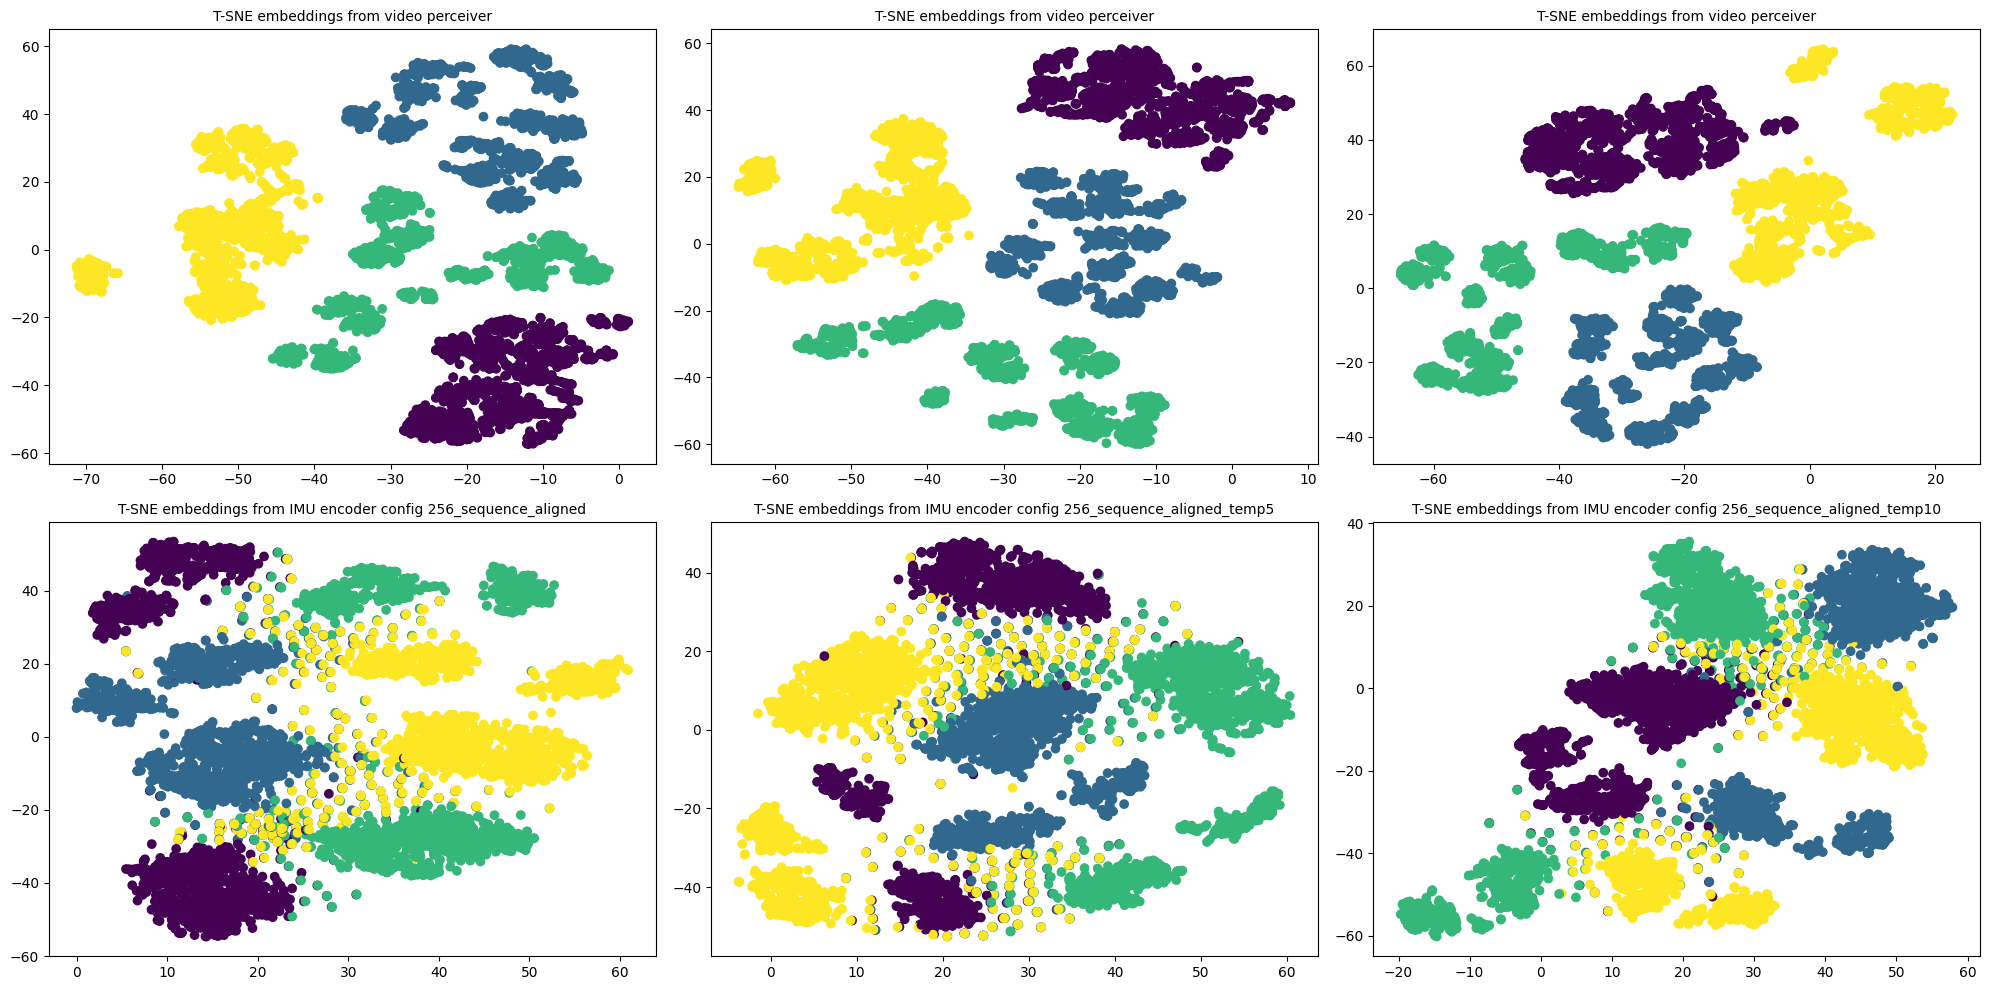

In [42]:
# Apply T-SNE transformation
from sklearn.preprocessing import StandardScaler
scalers = [StandardScaler() for _ in range(3)]
shared_tsne_space = True
num_latents = 4
if shared_tsne_space:
    # Combine all embeddings into a single array for shared t-SNE space
    num_points = imuEmbeds[0][:,:num_latents,:].reshape(-1,1024).shape[0]
    all_embeddings = [np.vstack((videoEmbedsPerceiver[:,:num_latents,:].reshape(-1,1024), imuEmbeds[:,:num_latents,:].reshape(-1,1024))) for imuEmbeds in imuEmbeds_all]
    all_embeddings_2d = [TSNE(n_components=2, perplexity=50, learning_rate=100).fit_transform(scaler.fit_transform(embeddings)) for embeddings, scaler in zip(all_embeddings,scalers)]
    
    videoEmbedsPerceiver_2d = [embeddings_2d[:num_points] for embeddings_2d in all_embeddings_2d]
    imuEmbeds_2d_all = [embeddings_2d[-num_points:] for embeddings_2d in all_embeddings_2d]
else:
    videoEmbedsPerceiver_2d = [TSNE(n_components=2).fit_transform(videoEmbedsPerceiver[:,:num_latents,:].reshape(-1, 1024))]
    imuEmbeds_2d_all = [TSNE(n_components=2).fit_transform(imuEmbeds[:,:num_latents,:].reshape(-1,1024)) for imuEmbeds in imuEmbeds_all]

# Plot the embeddings
le = LabelEncoder()
numerical_labels = le.fit_transform(labels)
latent_labels = np.array([i for i in range(num_latents)])
latent_labels = np.tile(latent_labels,len(labels))

# Create a grid of subplots with 3 rows and 4 columns
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for i, videoEmbeds_2d in enumerate(videoEmbedsPerceiver_2d):
    ax[0, i].scatter(videoEmbeds_2d[:, 0], videoEmbeds_2d[:, 1], c=latent_labels, cmap='viridis')
    ax[0, i].set_title('t-SNE embeddings from video perceiver', fontsize=10)

# Remove the unused subplots in the top right
if not shared_tsne_space:
    fig.delaxes(ax[0, 0])
    fig.delaxes(ax[0, 2])

# Plot IMU embeddings in the 2nd and 3rd rows
for i, imuEmbeds_2d in enumerate(imuEmbeds_2d_all):
    row = 1 if i < 2 else 2  # Determine the row based on the config index
    col = i if i < 2 else i - 2  # Determine the column based on the config index
    config_name = list(configs.keys())[i] #list(configs[i].keys())[0]  # Assume the config key name is the first key in each config dictionary
    ax[1, i].scatter(imuEmbeds_2d[:, 0], imuEmbeds_2d[:, 1], c=latent_labels, cmap='viridis')
    ax[1, i].set_title(f't-SNE embeddings from IMU encoder config {config_name}', fontsize=10)

plt.tight_layout()  # Adjusts subplot params so that subplots do not overlap
plt.show()

In [ ]:
# Apply T-SNE transformation
from sklearn.preprocessing import StandardScaler
scalers = [StandardScaler() for _ in range(3)]
shared_tsne_space = True
num_latents = 4

if 'all_embeddings_2d' not in globals():
    if shared_tsne_space:
        # Combine all embeddings into a single array for shared t-SNE space
        num_points = imuEmbeds[0][:,:num_latents,:].reshape(-1,1024).shape[0]
        all_embeddings = [np.vstack((videoEmbedsPerceiver[:,:num_latents,:].reshape(-1,1024), imuEmbeds[:,:num_latents,:].reshape(-1,1024))) for imuEmbeds in imuEmbeds_all]
        all_embeddings_2d = [TSNE(n_components=2, perplexity=50, learning_rate=100).fit_transform(scaler.fit_transform(embeddings)) for embeddings, scaler in zip(all_embeddings,scalers)]

        videoEmbedsPerceiver_2d = [embeddings_2d[:num_points] for embeddings_2d in all_embeddings_2d]
        imuEmbeds_2d_all = [embeddings_2d[-num_points:] for embeddings_2d in all_embeddings_2d]
    else:
        videoEmbedsPerceiver_2d = [TSNE(n_components=2).fit_transform(videoEmbedsPerceiver[:,:num_latents,:].reshape(-1, 1024))]
        imuEmbeds_2d_all = [TSNE(n_components=2).fit_transform(imuEmbeds[:,:num_latents,:].reshape(-1,1024)) for imuEmbeds in imuEmbeds_all]

# Plot the embeddings
le = LabelEncoder()
numerical_labels = le.fit_transform(labels)
numerical_labels = np.repeat(numerical_labels, num_latents)
latent_labels = np.array([i for i in range(num_latents)])
latent_labels = np.tile(latent_labels,len(labels))

# Create a grid of subplots with 3 rows and 4 columns
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for i, videoEmbeds_2d in enumerate(videoEmbedsPerceiver_2d):
    if i != 1: continue
    sc = ax[0].scatter(videoEmbeds_2d[:, 0], videoEmbeds_2d[:, 1], c=latent_labels, cmap='viridis')
    ax[0].set_title('t-SNE embeddings from video perceiver', fontsize=10)

# Remove the unused subplots in the top right
if not shared_tsne_space:
    fig.delaxes(ax[0, 0])
    fig.delaxes(ax[0, 2])

# Plot IMU embeddings in the 2nd and 3rd rows
for i, imuEmbeds_2d in enumerate(imuEmbeds_2d_all):
    if i != 1: continue
    config_name = list(configs.keys())[i] #list(configs[i].keys())[0]  # Assume the config key name is the first key in each config dictionary
    ax[i].scatter(imuEmbeds_2d[:, 0], imuEmbeds_2d[:, 1], c=latent_labels, cmap='viridis')
    ax[i].set_title(f't-SNE embeddings from IMU encoder', fontsize=10)

plt.legend(*sc.legend_elements(), title="Latent Vector", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()  # Adjusts subplot params so that subplots do not overlap
plt.savefig('TSNE.png')
plt.show()